# Introduction

Text clustering is a method of processing the unlabeled texts into groups or clusters therefore this NLP analysis is called text clustering.It is one of the unsupervised learning techniques that depends on grouping the texts according to their similarity. Imagine you are a librarian and you want to group the books into grouos and subgroups according to their similarity on their authors and their scopes as well [1]. In this project, Text Clustering pipeline consists of five main components:

1. **Data Cleaning:** this step includes uploding gutenberg's five books with different genres and different authors. The selected geres are: Fiction, Mystery, Science, Detective, and Novel.

2. **Data Partitioning:** the raw text books are partioned into 200 partitions randomly. each partition consists of 150 words. 

3. **Feature Engineering:** the raw dataset is transformed into vectors that can be used in a machine learning model. this step includes creating new features.

4. **Clustering:** training different clustering algorithms for further selecting the best algorithm.

5. **Evaluation:** if this clustering define separations of the data similar to some ground truth set of classes or satisfying some assumption such that members belong to the same class are more similar than members of different classes according to some similarity metric [2].

We used different feature engineering techniques with different clustering algorithms to select the champoin clusterer in the end. in addition, we did some clustering performance evaluations to measure different parametes as:  Silhouette Coefficient to determine the better defined clusters, cohen's kappa to measure the inter-agreement, v-measure to measure the homogenity and completeness of the clustering, and normalized mutual information score to measure the coherence between the clusters. Finally we did some error analysis like Principal component analysis (PCA) visualization to the best clusterer, and top 10 frequent words to the mislabeled partition.

# Libraries

For dataset preparation, feature engineering, model training & Evaluation.

In [1]:
import nltk
import re
import pandas as pd
import numpy as np
import random
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import gensim

from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer,TfidfVectorizer
# import hierarchical clustering libraries
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.model_selection import GridSearchCV , cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing , decomposition ,ensemble
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.mixture import GaussianMixture

from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score
from keras.preprocessing import text, sequence
from mlxtend.evaluate import bias_variance_decomp 

import ipywidgets as widgets
from IPython import display


# Data Cleaning

Data cleaning is a pre-processing step for text clustering. it's a problem dependent step because there are various techniques for data cleaning but we select the most appropriate one for our data as well as our goal. First, we normalized the data by converting the text to lowercase. Second, we removed some noise like panctuations, links, and numbers. Third, we removed the stop words. Then, we did lemmatisation in which a Part of speech(POS) of each word is determined and then different rules are applied for different POS[3]. Finally, we removed some words that are repeated alot in the five books according to their collocation analysis. these words mislabel the clusters. Examples of these words: 'gutenberg', 'book', 'project', 'electronic'. 

> Preprocessing Function.

In [2]:
nltk.download('stopwords')
lst_stopwords = nltk.corpus.stopwords.words("english")
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True,printt = False):#, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', ' ', str(text).lower().strip())
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ", text)
    text = re.sub("\d+", " ", text)
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    if printt:
        print(f'number of words before removing stop words = {len(lst_text)}')
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    if printt:   
        print(f'number of words after removing stop words = {len(lst_text)}')
    
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Partitioning

In [3]:
def read_books(path): #function to read the book
    book = open(path).read()
    return book

b1= read_books('../input/books-data/data/The_Mikado_Jewel_by_Fergus_Hume.txt')
b2= read_books('../input/books-data/data/A_Strange_Disappearance_by_Anna_Katharine_Green.txt')
b3= read_books('../input/books-data/data/Nor_Iron_Bars_a_Cage...._by_Randall_Garrett.txt')
b4= read_books('../input/books-data/data/The_Secret_of_Chimneys_by_Agatha_Christie.txt')
b5= read_books('../input/books-data/data/The_Spoils_of_Poynton_by_Henry_James.txt')
label = ["Fiction", "Mystery", "Science", "Detective","Novel"]
books = [b1, b2, b3, b4, b5]
def partitation_book(): #function for partitioning
    final_list = []# hold the final result of all used books
    words = ""
    for book in range(0, 5):
        cleaned_text = utils_preprocess_text(books[book],flg_stemm=False, flg_lemm=True,printt = True)
        book_tokenized_words = nltk.word_tokenize(cleaned_text)#get the words' tokens for every book
        for partition in range(0, 200):#start 200 partition from every single book
            random_word_index= random.choice(range(len(book_tokenized_words))) #Create (random?!) samples of 200 partitions of the book.
            if random_word_index <= (len(book_tokenized_words)):
                part = book_tokenized_words[random_word_index : random_word_index+150]
            else: 
                random_word_index = random_word_index - 150
                part = book_tokenized_words[random_word_index : random_word_index+150]
            words = " ".join(part)  
            final_list.append((label.index(label[book]), words))
            words = ' '
    list_df = pd.DataFrame(final_list, columns=["genre", "cleaned_text"]) #convert the final list to dataframe for further analysis.
    return list_df
        
data_df = partitation_book()
data_df

number of words before removing stop words = 77013
number of words after removing stop words = 36997
number of words before removing stop words = 53776
number of words after removing stop words = 24840
number of words before removing stop words = 20072
number of words after removing stop words = 9410
number of words before removing stop words = 79020
number of words after removing stop words = 37984
number of words before removing stop words = 74426
number of words after removing stop words = 32380


,genre,cleaned_text
0,0,get touch physical body weak get touch asked p...
1,0,rainbow slid deft hand theodore wondered got e...
2,0,big man wrestled desperately theodore ghastly ...
3,0,demanded second glass brought colour back wan ...
4,0,moment seemed force appeared falter weaken lig...
...,...,...
995,4,walk every graceless jerk hurt seemed endless ...
996,4,maiden aunt sure deeply suffered sure hope how...
997,4,management way lover whatever found separated ...
998,4,must like absence luggage made young woman fee...


In [4]:
data_df['tokenized'] = data_df['cleaned_text'].apply(lambda x: nltk.tokenize.word_tokenize(x)) #insert a column which contains the tokenized words of each partition.
data_df['words_length'] = data_df['tokenized'].apply(lambda x: len(x)) #insert a column which contains the length of the words in each partition.
display.display(data_df)

,genre,cleaned_text,tokenized,words_length
0,0,get touch physical body weak get touch asked p...,"[get, touch, physical, body, weak, get, touch,...",150
1,0,rainbow slid deft hand theodore wondered got e...,"[rainbow, slid, deft, hand, theodore, wondered...",150
2,0,big man wrestled desperately theodore ghastly ...,"[big, man, wrestled, desperately, theodore, gh...",150
3,0,demanded second glass brought colour back wan ...,"[demanded, second, glass, brought, colour, bac...",150
4,0,moment seemed force appeared falter weaken lig...,"[moment, seemed, force, appeared, falter, weak...",150
...,...,...,...,...
995,4,walk every graceless jerk hurt seemed endless ...,"[walk, every, graceless, jerk, hurt, seemed, e...",150
996,4,maiden aunt sure deeply suffered sure hope how...,"[maiden, aunt, sure, deeply, suffered, sure, h...",150
997,4,management way lover whatever found separated ...,"[management, way, lover, whatever, found, sepa...",150
998,4,must like absence luggage made young woman fee...,"[must, like, absence, luggage, made, young, wo...",150


# Data Analysis using top 10 frequent words per each book.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col f

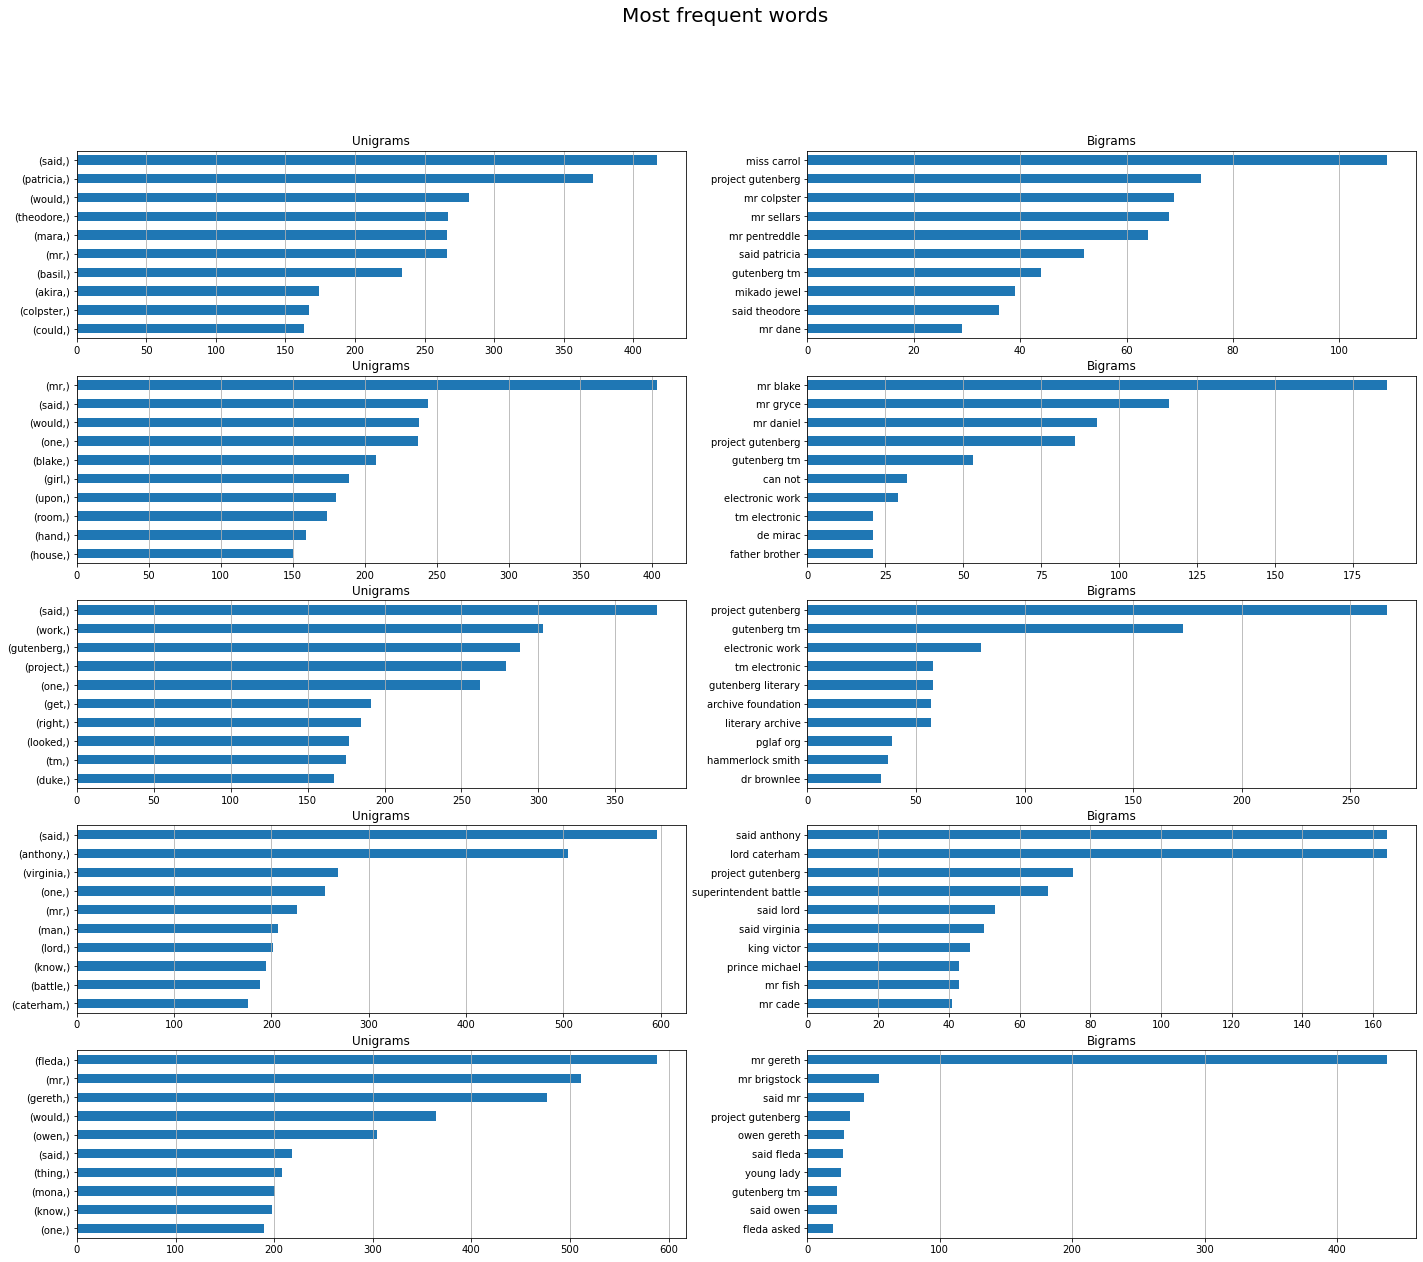

In [5]:
in_cluster_ids = [0,1,2,3,4]
top = 10
fig, ax = plt.subplots(nrows=5, ncols=2,figsize=(24, 20))
ax = ax.ravel()
for i in range(len(in_cluster_ids)):
    corpus = data_df[data_df["genre"]== in_cluster_ids[i]]["cleaned_text"]
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    fig.suptitle(f"Most frequent words", fontsize=20)
        ## unigrams
    dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 1))
    dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                           columns=["Word","Freq"])
    dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                      kind="barh", title="Unigrams", ax=ax[i*2], 
                      legend=False).grid(axis='x')
    ax[i*2].set(ylabel=None)

    ## bigrams
    dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
    dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                          columns=["Word","Freq"])
    dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                       string for string in x) )
    dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                      kind="barh", title="Bigrams", ax=ax[(i*2)+1],
                      legend=False).grid(axis='x')
    ax[(i*2)+1].set(ylabel=None)
plt.savefig('./before_clening.jpg', dpi = 250)
plt.show()

# Removing the most repeated words that doesn't indicate any information about the labels.

In [6]:
pattern = r"(gutenberg)|(book)|(electronic)|(project)|(said)"
data_df['cleaner'] = data_df['cleaned_text'].apply(lambda x: re.sub(pattern,"",x))
data_df

,genre,cleaned_text,tokenized,words_length,cleaner
0,0,get touch physical body weak get touch asked p...,"[get, touch, physical, body, weak, get, touch,...",150,get touch physical body weak get touch asked p...
1,0,rainbow slid deft hand theodore wondered got e...,"[rainbow, slid, deft, hand, theodore, wondered...",150,rainbow slid deft hand theodore wondered got e...
2,0,big man wrestled desperately theodore ghastly ...,"[big, man, wrestled, desperately, theodore, gh...",150,big man wrestled desperately theodore ghastly ...
3,0,demanded second glass brought colour back wan ...,"[demanded, second, glass, brought, colour, bac...",150,demanded second glass brought colour back wan ...
4,0,moment seemed force appeared falter weaken lig...,"[moment, seemed, force, appeared, falter, weak...",150,moment seemed force appeared falter weaken lig...
...,...,...,...,...,...
995,4,walk every graceless jerk hurt seemed endless ...,"[walk, every, graceless, jerk, hurt, seemed, e...",150,walk every graceless jerk hurt seemed endless ...
996,4,maiden aunt sure deeply suffered sure hope how...,"[maiden, aunt, sure, deeply, suffered, sure, h...",150,maiden aunt sure deeply suffered sure hope how...
997,4,management way lover whatever found separated ...,"[management, way, lover, whatever, found, sepa...",150,management way lover whatever found separated ...
998,4,must like absence luggage made young woman fee...,"[must, like, absence, luggage, made, young, wo...",150,must like absence luggage made young woman fee...


# Visualizing the top 10 frequent words after noise removal.

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col f

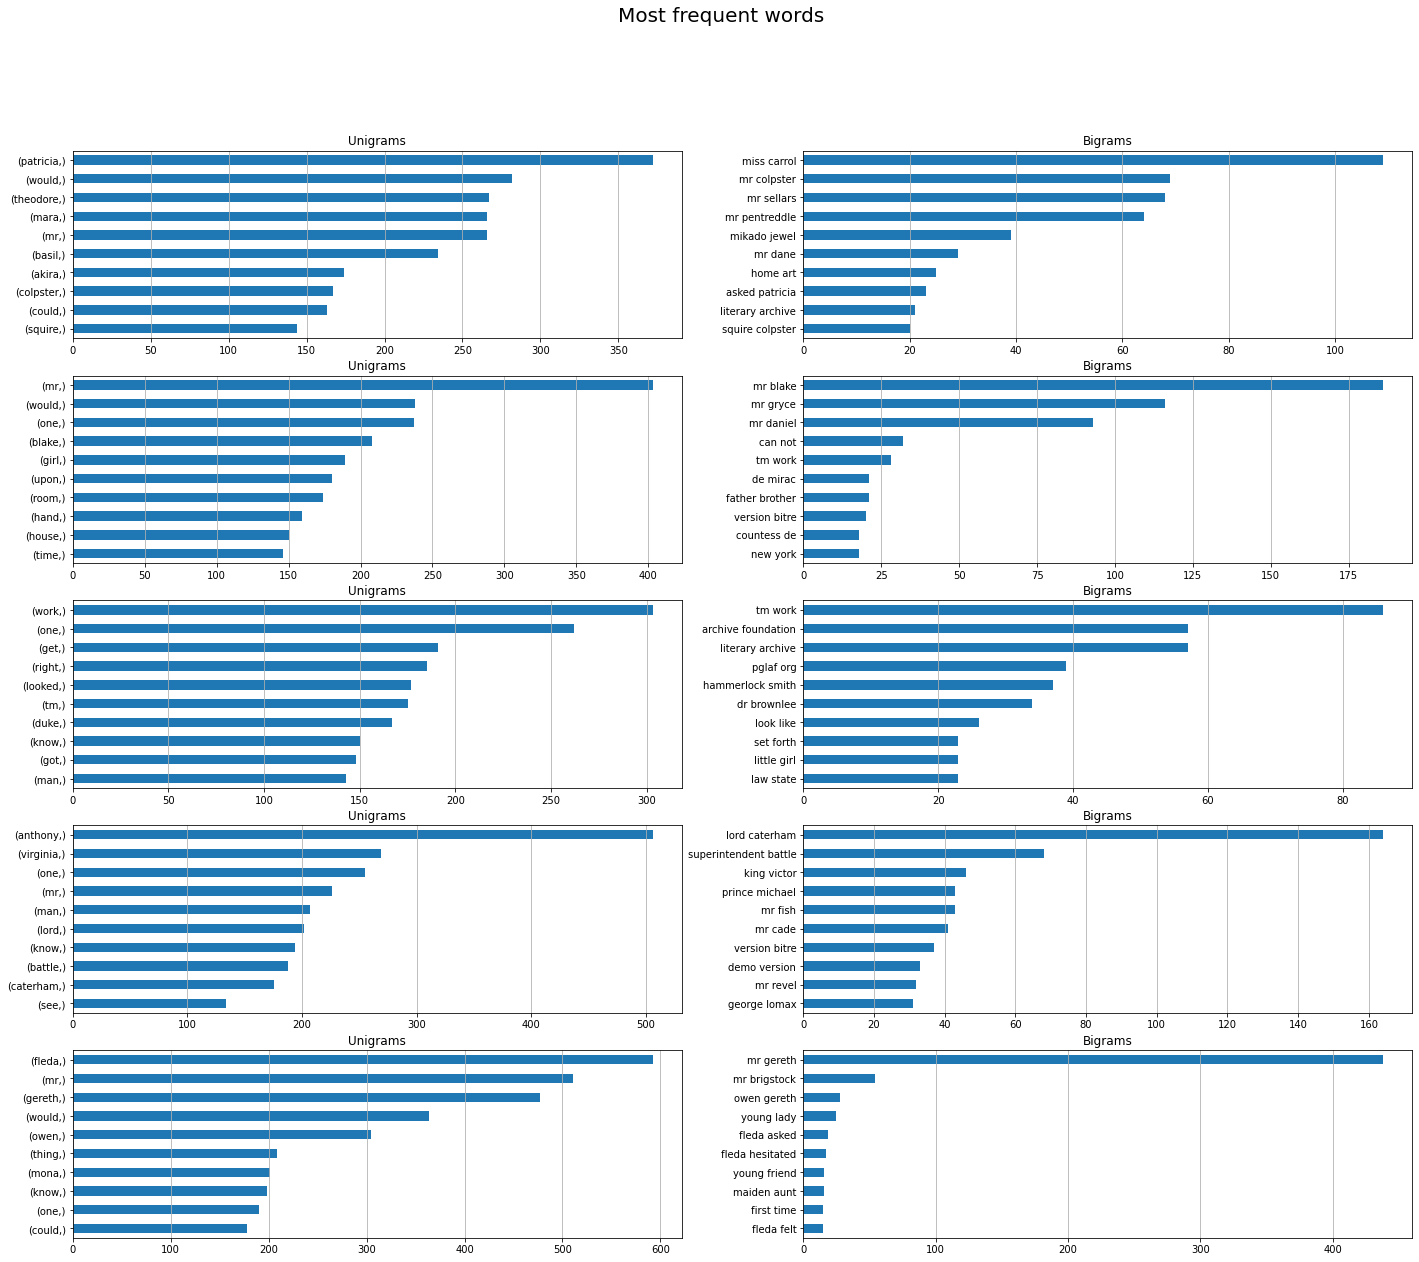

In [7]:
fig, ax = plt.subplots(nrows=5, ncols=2,figsize=(24, 20))
ax = ax.ravel()
for i in range(len(in_cluster_ids)):
    corpus = data_df[data_df["genre"]== in_cluster_ids[i]]["cleaner"]
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    fig.suptitle(f"Most frequent words", fontsize=20)
        ## unigrams
    dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 1))
    dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                           columns=["Word","Freq"])
    dtf_uni.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                      kind="barh", title="Unigrams", ax=ax[i*2], 
                      legend=False).grid(axis='x')
    ax[i*2].set(ylabel=None)

    ## bigrams
    dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
    dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                          columns=["Word","Freq"])
    dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                       string for string in x) )
    dtf_bi.set_index("Word").iloc[:top,:].sort_values(by="Freq").plot(
                      kind="barh", title="Bigrams", ax=ax[(i*2)+1],
                      legend=False).grid(axis='x')
    ax[(i*2)+1].set(ylabel=None)
plt.savefig('./after_clening.jpg', dpi = 250)
plt.show()

# Visualizing the top collocations of each book and calculting the PMI.

Collocations are phrases or expressions containing multiple words, that are highly likely to co-occur. For example: ‘social media’, ‘school holiday’, ‘machine learning’, and ‘Universal Studios Singapore’. Collocations helped me in fetching the two or three words that are highly likely to co-occur around these themes. collocations differs than bigram and trigrams in the technique by which it collects the words. it measures the similarity between two words and gives meaningful collection [4].

In [8]:
for in_cluster_id in in_cluster_ids:
    print(f'===================Collocataion of book {in_cluster_id}:======================================')
    corpus = data_df[data_df["genre"]== in_cluster_id]["cleaner"]
    tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    bigrams = nltk.collocations.BigramAssocMeasures()
    trigrams = nltk.collocations.TrigramAssocMeasures()
    bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
    trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
    bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)
    trigramPMITable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.pmi)), columns=['trigram','PMI']).sort_values(by='PMI', ascending=False)

    # create output widgets
    widget1 = widgets.Output()
    widget2 = widgets.Output()

    # render in output widgets
    with widget1:
        display.display(bigramPMITable)
    with widget2:
        display.display(trigramPMITable)

    # create HBox
    hbox = widgets.HBox([widget1, widget2])

    # render hbox
    display.display(hbox)

===================Collocataion of book 0:======================================


===================Collocataion of book 1:======================================


===================Collocataion of book 2:======================================


===================Collocataion of book 3:======================================


===================Collocataion of book 4:======================================


> Variables in which the data is stored.

In [9]:
X_train = data_df['cleaner']
y_train = data_df['genre']

# Feature Engineering

We can't use the text itself by machine learning. so, it should be converted into vectors with a numeric values. There are various approaches from which we used in this project. For example: Bag of Words(BOW), term frequency inverse document frequency (TF-IDF), and word embeddings [5].

# BOW

Count Vectors as features (BOW) Count Vector is a matrix notation of the dataset in which every row represents a document from the text, every column represents a term from the text, and every cell represents the frequency count of a particular term in a particular document.

In [10]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(X_train)

# transform the training and validation data using count vectorizer object
xtrain_BOW =  count_vect.transform(X_train)

# TF-IDF

TF-IDF score represents the relative importance of a term in the document and the entire text. TF-IDF score is composed by two terms:

* the first computes the normalized Term Frequency (TF),

* the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document) IDF(t) = log_e(Total number of documents / Number of documents with term t in it)

TF-IDF Vectors can be generated at different levels of input tokens (words, characters, n-grams):

* Word Level TF-IDF : Matrix representing tf-idf scores of every term in different documents

* N-gram Level TF-IDF : N-grams are the combination of N terms together. This Matrix representing tf-idf scores of N-grams

In [11]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(X_train)
xtrain_tfidf_unigram =  tfidf_vect.transform(X_train)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,2), max_features=5000)
tfidf_vect_ngram.fit(X_train)
xtrain_tfidf_bigram =  tfidf_vect_ngram.transform(X_train)
# print(xtrain_tfidf_ngram)

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(X_train)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)

# Word Embeddings
It is a numeric vector input that represents a word in a lower-dimensional space. It allows words with similar meaning to have a similar representation. it's goal is: reducing dimensionality, using a word to predict the words around it, capturing inter word semantics. the words are taken and trained using machine learning models [6]. In the project, we use gensim library for word embedding training nad extracting the features that were used in clustering.

In [12]:
tokenized_corpus = data_df['tokenized'] #the data as tokens
model = gensim.models.Word2Vec(tokenized_corpus, min_count=1 ) #training the data using word2vec method in gensim library.
 

> Extracting features from word embedding methods.

In [13]:
X_embedd_list = model.wv.index_to_key
X_embedd = model.wv[X_embedd_list]


# Clustering

We used three algorithms for clustering: 

* **kmeans:** it is trying to seperate the samples into number of groups, each group has equal variance. it divides the data into disjoint clusters that are described by the mean which is called the centroid [2].

* **Hierarchial clustering:** it's a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample [2].

* **Expectatation maximization (Gaussian Mixture):** it is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians [2].

In [14]:
featured_x_train = [xtrain_BOW , xtrain_tfidf_unigram , xtrain_tfidf_bigram, xtrain_tfidf_ngram] #a list which contains all outputs from feature engineering 
                                                                                                        #and considered as input features to clustering models
km_kappa = []
km_silhouette = []
km_coherence = []
agg_kappa = []
agg_silhouette = []
agg_coherence = []
em_kappa = []
em_silhouette = []
em_coherence = []
km_v_measure = []
agg_v_measure = []
em_v_measure = []

In [15]:
true_k = np.unique(data_df['genre']).shape[0]
true_k #number of clusters =  number of labels

5

# Applying clustering algorithms and holding the results of performance evaluation metrics to lists for further analysis.

The lists are holding the results of performance evaluation metrics like silhoutte co-efficent, kappa, coherence, and v-measure.

In [16]:
for i in featured_x_train:
    kms = KMeans(n_clusters=true_k, init='k-means++', max_iter=300,n_init = 1,random_state=42,verbose=0)
    kms.fit(i)
    km_kappa.append(metrics.cohen_kappa_score(y_train, kms.labels_))
    km_silhouette.append(metrics.silhouette_score(i, kms.labels_))
    km_coherence.append(metrics.normalized_mutual_info_score(y_train, kms.labels_))
    km_v_measure.append(metrics.v_measure_score(y_train, kms.labels_))
    
    cluster = AgglomerativeClustering(n_clusters=true_k, affinity='euclidean', linkage='ward')
    cluster.fit(i.todense())
    agg_kappa.append(metrics.cohen_kappa_score(y_train, cluster.labels_))
    agg_silhouette.append(metrics.silhouette_score(i, cluster.labels_))
    agg_coherence.append(metrics.normalized_mutual_info_score(y_train, kms.labels_))
    agg_v_measure.append(metrics.v_measure_score(y_train, kms.labels_))
    
    
    gm = GaussianMixture(n_components= true_k, covariance_type = 'diag',random_state=42)
    gm.fit(i.toarray())
    em_kappa.append(metrics.cohen_kappa_score(y_train, gm.predict(i.toarray())))
    em_silhouette.append(metrics.silhouette_score(i, gm.predict(i.toarray())))
    em_coherence.append(metrics.normalized_mutual_info_score(y_train, gm.predict(i.toarray())))
    em_v_measure.append(metrics.v_measure_score(y_train, gm.predict(i.toarray())))
    


# Applying clustering algorithms on word embeddings and evaluate the silhoutte coefficent.

In [17]:
kms = KMeans(n_clusters=true_k, init='k-means++', max_iter=300,n_init = 1,random_state=42,verbose=0)
kms.fit(X_embedd)
embed_pred = kms.labels_
km_silhouette.append(metrics.silhouette_score(X_embedd, kms.labels_))

cluster = AgglomerativeClustering(n_clusters=true_k, affinity='euclidean', linkage='ward')
cluster.fit(X_embedd)
agg_silhouette.append(metrics.silhouette_score(X_embedd, cluster.labels_))


gm = GaussianMixture(n_components= true_k, covariance_type = 'tied',random_state=42)
gm.fit(X_embedd)
em_silhouette.append(metrics.silhouette_score(X_embedd, gm.predict(X_embedd)))

# Evaluation

Evaluating the performance of a clustering algorithm is not as trivial as counting the number of errors or the precision and recall of a supervised classification algorithm. In particular any evaluation metric should not take the absolute values of the cluster labels into account but rather if this clustering define separations of the data similar to some ground truth set of classes or satisfying some assumption such that members belong to the same class are more similar than members of different classes according to some similarity metric [2]. we use in this project four performance evaluation metrics:

* Silhouette coefficient: A measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). its range is [-1,1], The higher value, the better avg match is within the cluster.

* Cohen's Kappa: measures the inter-agreement between two classifiers.

* Normalized matual information score (Cohesion Evaluation): it is a function that measures the agreement of the two assignments, ignoring permutations.

* V_measure: it is the harmonic mean of homogenity score -each cluster contains only members of a single class- and completeness score -all members of a given class are assigned to the same cluster- [2].

# Silhoutee Coefficient

In [18]:
evaluation = ['k-means_silhouette','Hierarchical_silhouette','EM_silhouette']
silhouette_results_df = pd.DataFrame((km_silhouette,agg_silhouette,em_silhouette) , columns =  ['xtrain_BOW' , 'xtrain_tfidf_unigram' , 'xtrain_tfidf_bigram', 'xtrain_tfidf_ngram', 'X_Embedding'])
silhouette_results_df['Evaluation'] = evaluation
silhouette_results_df.set_index('Evaluation')
first_col = silhouette_results_df.pop('Evaluation')
silhouette_results_df.insert(0, 'Evaluation', first_col)
display.display(silhouette_results_df)

,Evaluation,xtrain_BOW,xtrain_tfidf_unigram,xtrain_tfidf_bigram,xtrain_tfidf_ngram,X_Embedding
0,k-means_silhouette,0.035816,0.023348,0.022441,0.016737,0.668579
1,Hierarchical_silhouette,0.038425,0.035805,0.020325,0.028864,0.634582
2,EM_silhouette,0.035742,0.023389,0.024835,0.012213,0.721196


# V-measure

In [19]:
evaluation =  ['k-means_v_measure','Hierarchical_v_measure','EM_v_measure']
v_measure_results_df = pd.DataFrame((km_v_measure,agg_v_measure,em_v_measure) , columns =  ['xtrain_BOW' , 'xtrain_tfidf_unigram' , 'xtrain_tfidf_bigram', 'xtrain_tfidf_ngram'])
v_measure_results_df['Evaluation'] = evaluation
v_measure_results_df.set_index('Evaluation')
first_col = v_measure_results_df.pop('Evaluation')
v_measure_results_df.insert(0, 'Evaluation', first_col)
display.display(v_measure_results_df)

,Evaluation,xtrain_BOW,xtrain_tfidf_unigram,xtrain_tfidf_bigram,xtrain_tfidf_ngram
0,k-means_v_measure,0.564475,0.730180,0.419387,0.371727
1,Hierarchical_v_measure,0.564475,0.730180,0.419387,0.371727
2,EM_v_measure,0.570031,0.732866,0.391581,0.338895


# Cohen's Kappa 

In [20]:
evaluation =  ['k-means_kappa','Hierarchical_kappa','EM_kappa']
kappa_results_df = pd.DataFrame((km_kappa,agg_kappa,em_kappa) , columns =  ['xtrain_BOW' , 'xtrain_tfidf_unigram' , 'xtrain_tfidf_bigram', 'xtrain_tfidf_ngram'])
kappa_results_df['Evaluation'] = evaluation
kappa_results_df.set_index('Evaluation')
first_col = kappa_results_df.pop('Evaluation')
kappa_results_df.insert(0, 'Evaluation', first_col)
display.display(kappa_results_df)

,Evaluation,xtrain_BOW,xtrain_tfidf_unigram,xtrain_tfidf_bigram,xtrain_tfidf_ngram
0,k-means_kappa,0.02000,0.19875,0.03875,-0.16375
1,Hierarchical_kappa,0.00125,0.00375,-0.03250,-0.00375
2,EM_kappa,0.02000,0.20125,-0.00125,-0.16125


# Normalized mutual information score (Coherence)

In [21]:
evaluation =  ['k-means_coherence','Hierarchical_coherence','EM_coherence']
coherence_results_df = pd.DataFrame((km_coherence,agg_coherence,em_coherence) , columns =  ['xtrain_BOW' , 'xtrain_tfidf_unigram' , 'xtrain_tfidf_bigram', 'xtrain_tfidf_ngram'])
coherence_results_df['Evaluation'] = evaluation
coherence_results_df.set_index('Evaluation')
first_col = coherence_results_df.pop('Evaluation')
coherence_results_df.insert(0, 'Evaluation', first_col)
display.display(coherence_results_df)

,Evaluation,xtrain_BOW,xtrain_tfidf_unigram,xtrain_tfidf_bigram,xtrain_tfidf_ngram
0,k-means_coherence,0.564475,0.730180,0.419387,0.371727
1,Hierarchical_coherence,0.564475,0.730180,0.419387,0.371727
2,EM_coherence,0.570031,0.732866,0.391581,0.338895


# Results Visualizations

In the below figure, we can see that k-means is the highest silhoutte coefficient value when word embeddings are applied as feature engineering. the x-axis is the algorithms we used, y-axis is the silhoutte coefficient, and colered graphs are the different applied feature engineering to the clustering models.

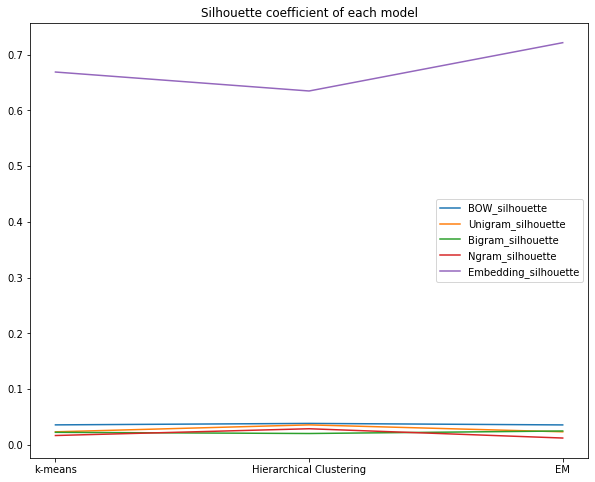

In [22]:
models = ['k-means' , 'Hierarchical Clustering' , 'EM']
# algorithm comparison
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
plt.plot(models , [km_silhouette[0], agg_silhouette[0] , em_silhouette[0]] , label = 'BOW_silhouette')
plt.plot(models , [km_silhouette[1], agg_silhouette[1] , em_silhouette[1]] , label = 'Unigram_silhouette')
plt.plot(models , [km_silhouette[2], agg_silhouette[2] , em_silhouette[2]] , label = 'Bigram_silhouette')
plt.plot(models , [km_silhouette[3], agg_silhouette[3] , em_silhouette[3]] , label = 'Ngram_silhouette')
plt.plot(models , [km_silhouette[4], agg_silhouette[4] , em_silhouette[4]] , label = 'Embedding_silhouette')
plt.legend()
plt.title('Silhouette coefficient of each model')
plt.savefig('silhoutte.png' , dpi = 250)
plt.show()

In the below figure, we can see that k-means is the highest Normalized mutual information score when unigram TF-IDF are applied as feature engineering. the x-axis is the algorithms we used, y-axis is the silhoutte coefficient, and colered graphs are the different applied feature engineering to the clustering models.

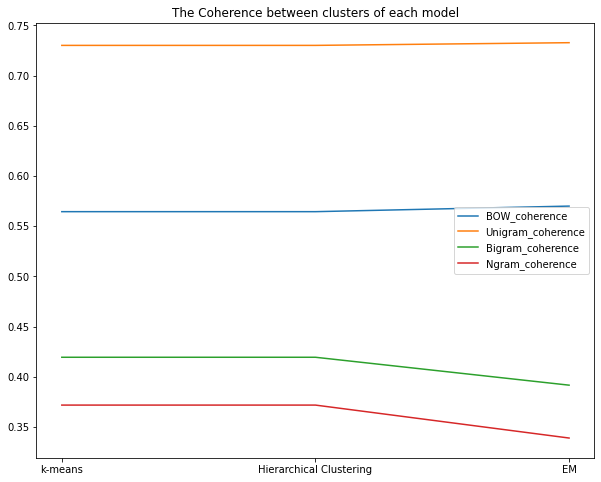

In [23]:
models = ['k-means' , 'Hierarchical Clustering' , 'EM']
# algorithm comparison
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
plt.plot(models , [km_coherence[0], agg_coherence[0] , em_coherence[0]] , label = 'BOW_coherence')
plt.plot(models , [km_coherence[1], agg_coherence[1] , em_coherence[1]] , label = 'Unigram_coherence')
plt.plot(models , [km_coherence[2], agg_coherence[2] , em_coherence[2]] , label = 'Bigram_coherence')
plt.plot(models , [km_coherence[3], agg_coherence[3] , em_coherence[3]] , label = 'Ngram_coherence')
plt.legend()
plt.title('The Coherence between clusters of each model')
plt.savefig('coherence.png' , dpi = 250)
plt.show()

In the below figure, we can see that k-means is the highest harmonic mean of homogenity and completeness score when unigram TF-IDF are applied as feature engineering. the x-axis is the algorithms we used, y-axis is the silhoutte coefficient, and colered graphs are the different applied feature engineering to the clustering models.

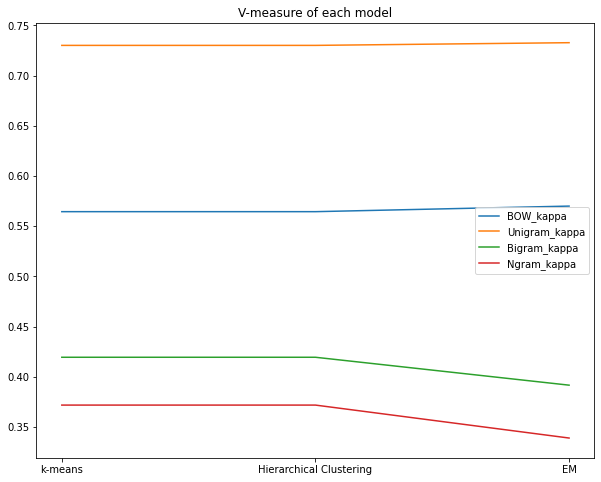

In [24]:
models = ['k-means' , 'Hierarchical Clustering' , 'EM']
# algorithm comparison
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
plt.plot(models , [km_v_measure[0], agg_v_measure[0] , em_v_measure[0]] , label = 'BOW_kappa')
plt.plot(models , [km_v_measure[1], agg_v_measure[1] , em_v_measure[1]] , label = 'Unigram_kappa')
plt.plot(models , [km_v_measure[2], agg_v_measure[2] , em_v_measure[2]] , label = 'Bigram_kappa')
plt.plot(models , [km_v_measure[3], agg_v_measure[3] , em_v_measure[3]] , label = 'Ngram_kappa')
plt.legend()
plt.title('V-measure of each model')
plt.savefig('vMeasure.png' , dpi = 250)
plt.show()

In the below figure, we can see that k-means is the highest Cohen's kappa score when unigram TF-IDF are applied as feature engineering. the x-axis is the algorithms we used, y-axis is the silhoutte coefficient, and colered graphs are the different applied feature engineering to the clustering models.

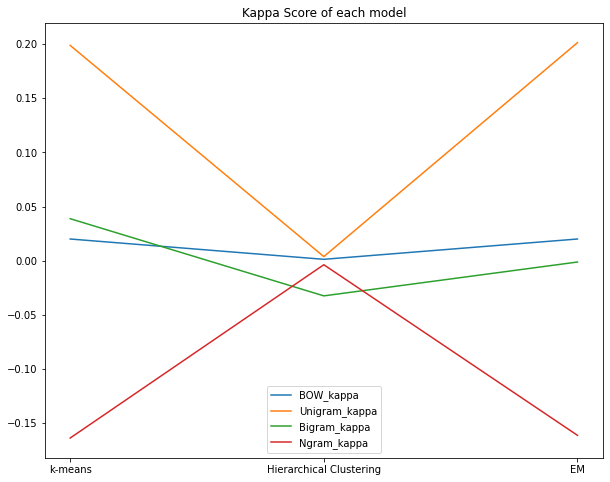

In [25]:
models = ['k-means' , 'Hierarchical Clustering' , 'EM']
# algorithm comparison
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
plt.plot(models , [km_kappa[0], agg_kappa[0] , em_kappa[0]] , label = 'BOW_kappa')
plt.plot(models , [km_kappa[1], agg_kappa[1] , em_kappa[1]] , label = 'Unigram_kappa')
plt.plot(models , [km_kappa[2], agg_kappa[2] , em_kappa[2]] , label = 'Bigram_kappa')
plt.plot(models , [km_kappa[3], agg_kappa[3] , em_kappa[3]] , label = 'Ngram_kappa')
plt.legend()
plt.title('Kappa Score of each model')
plt.savefig('kappa.png' , dpi = 250)
plt.show()

# Error Analysis

# PCA

The figure describes the application of principal component analysis(PCA) to the features of the champion model (unigram kmeans) to visualize the clusters and analyze the evaluation metrics's results. we find that there is an interpolation between clusters therfore the silhoutte coefficent is around zero. In addition, there are coherence between clusters therefore the NMI value is high and equals 76%.

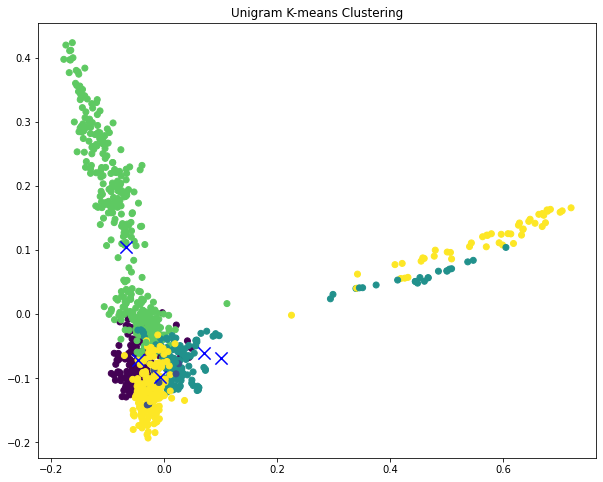

In [26]:
cls = KMeans(n_clusters=true_k, init='k-means++', max_iter=300,n_init = 1,random_state=42,verbose=0)
cls.fit(featured_x_train[1])
# reduce the features to 2D
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(featured_x_train[1].toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)
plt.figure(figsize = (10,8))
plt.title('Unigram K-means Clustering')
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(featured_x_train[1]))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
plt.savefig('cluster_results.png' , dpi = 250)

# Unigram/ Bigram Collocation

In [27]:
corpus = data_df['tokenized'][0]
bigrams = nltk.collocations.BigramAssocMeasures()
trigrams = nltk.collocations.TrigramAssocMeasures()
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)
trigramPMITable = pd.DataFrame(list(trigramFinder.score_ngrams(trigrams.pmi)), columns=['trigram','PMI']).sort_values(by='PMI', ascending=False)

# create output widgets
widget1 = widgets.Output()
widget2 = widgets.Output()

# render in output widgets
with widget1:
    display.display(bigramPMITable)
with widget2:
    display.display(trigramPMITable)

# create HBox
hbox = widgets.HBox([widget1, widget2])

# render hbox
display.display(hbox)

# Conclusion

Our champion model is k-means when word embeddings is applied as a feature engineering. in addition, there are interpolation between the clusters and the coherence is high as well. furthermore, Unigram TF-idf performs well within our data. For future work, we consider more feature engineering as LDA. in addition, selecting more appriopriate books that are differentiable. 

# References

1. https://khuloodnasher.medium.com/text-clustering f465ab60bc9a#:~:text=What%20is%20Text%20Clustering%3F%20Text%20clustering%20is%20a,on%20grouping%20the%20texts%20according%20to%20their%20similarity.

2. https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

3. https://www.geeksforgeeks.org/word-embeddings-in-nlp/

4. https://scikit-learn.org/stable/modules/clustering.html

5. https://sanjayasubedi.com.np/nlp/nlp-intro/

6. https://sanjayasubedi.com.np/nlp/nlp-feature-extraction/